The following block defines useful helper functions.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set figsize so that images are large enough
plt.rcParams['figure.figsize'] = [20, 10]

# A function to show a gray-scale image with its histogram side-by-side
def show_im_and_hist(originalImage, hist):
    plt.figure(figsize=(15,8))                              #set figure size and create 
    plt.subplot(121)
    plt.imshow(originalImage, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Image')

    plt.subplot(122)
    plt.bar(list(range(len(hist))),hist[:,0])                # Plot the histogram as a bar plot
    plt.title('histogram')
    plt.xlabel("Intensity"), plt.ylabel("count")
    plt.show()
    
#Function to show one or multiple images
def show_images(images):
    figwidth = 20; figheight = figwidth * images[0][0].shape[0]/images[0][0].shape[1]
    plt.figure(figsize=(figwidth,figheight))
    cols = 2
    rows = len(images) // 2 + 1
    for i, image in enumerate(images):
        plt.subplot(rows,cols,i+1)
        plt.imshow(image[0], cmap='gray')
        plt.title(str(image[1]))
        plt.xticks([]), plt.yticks([])
    plt.show()
    
# Function to show an RGB image
def imshow_rgb(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
# Function to make colorbars appear nicer
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

# Function to show a RGB image and three separate color channels
def show_rgb_plus_three_channels(img_bgr, ch_0, ch_1, ch_2, name_0, name_1, name_2, m_0=255, m_1=255, m_2=255):
    plt.subplot(2,2,1)
    imshow_rgb(img_bgr)
    plt.title('Color image')
    plt.subplot(2,2,2)
    img2 = plt.imshow(ch_0, cmap='gray', vmin=0, vmax=m_0)
    plt.title(name_0)
    colorbar(img2)
    plt.subplot(2,2,3)
    img3 = plt.imshow(ch_1, cmap='gray', vmin=0, vmax=m_1)
    plt.title(name_1)
    colorbar(img3)
    plt.subplot(2,2,4)
    img4 = plt.imshow(ch_2, cmap='gray', vmin=0, vmax=m_2)
    plt.title(name_2)
    colorbar(img4)
    
def calc_exgreen(img_bgr):
    # Convert to floating-point representation instead of uint8 to deal with fractions and negative values
    img_bgr_float = img_bgr.astype('float')
    R = img_bgr_float[:,:,2]
    G = img_bgr_float[:,:,1]
    B = img_bgr_float[:,:,0]
    g = G / (R+G+B)
    return(3*g-1)

def showImageHistogramAndOtsu(img_gray, hist, otsu_th, img_otsu):
    plt.figure(figsize=(20,8))
    plt.subplot(1,3,1)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Original image')

    plt.subplot(1,3,2)
    plt.bar(list(range(len(hist))),hist[:,0])                  # Plot the histogram as a bar plot
    #plt.plot([otsu_th, otsu_th], [0, np.max(hist)], color='r') # Plot the Otsu threshold
    plt.axvline(x=otsu_th, color='r', linestyle='dashed', linewidth=2)
    plt.title('histogram')
    plt.xlabel("Intensity"), plt.ylabel("count")

    plt.subplot(1,3,3)
    plt.imshow(img_otsu, cmap='gray')
    plt.title('Segmented image using Otsu with th = %d' % otsu_th)

    plt.show()

# Create an image with clear foreground and background with different levels of noise
def getTargetImageNoise():
    fg_val = 180
    bg_val = 75
    img_gray = fg_val*np.ones((200,200), dtype='uint8')
    cv2.circle(img_gray, (100,100), 80, (bg_val), -1)
    cv2.circle(img_gray, (100,100), 50, (fg_val), -1)
    cv2.circle(img_gray, (100,100), 20, (bg_val), -1)
    img_gray = img_gray + (1*np.random.randn(200,200)).astype('uint8')
    img_gray_low_noise = img_gray + (20*np.random.randn(200,200)).astype('uint8')
    img_gray_high_noise = img_gray + (50*np.random.randn(200,200)).astype('uint8')
    return(img_gray, img_gray_low_noise, img_gray_high_noise)

## Adaptive thresholding

Often, images contain non-uniform illumination, that is, different parts of the image have a different illumination, for instance due to shadows or differences in the orientation of 3D surfaces of objects. If this is the case, a global threshold cannot be used to segment the forground from the background. 

__Exercise (Otsu's method on Sudoku):__
* Inspect and run the following piece of code and observe the results. What do you see?

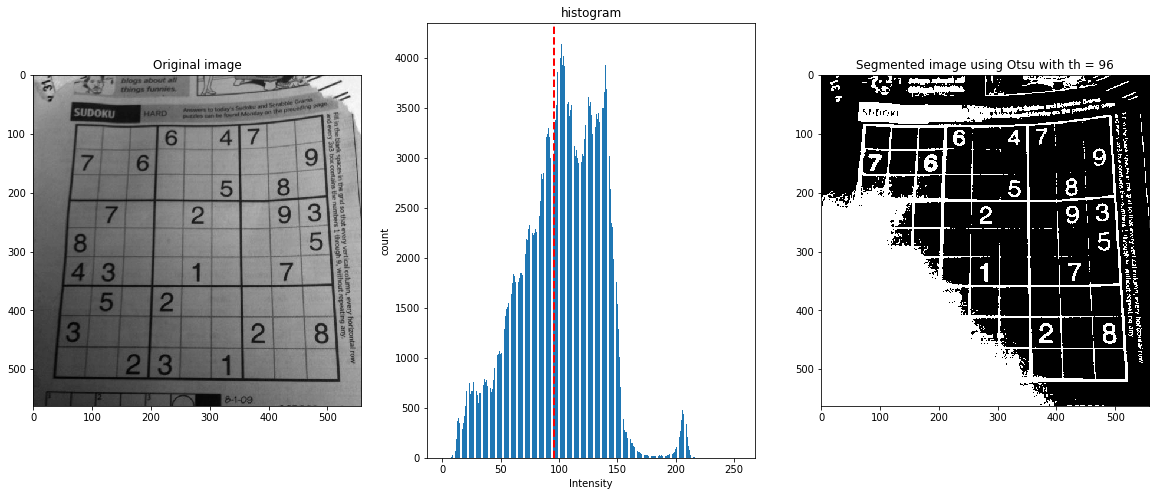

In [2]:
img_gray = cv2.imread('Data_Tutorial5/sudoku.png', 0)

# Calculate the histogram for this image
hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])#create histogram

# Calculate the Otsu threshold for the image
otsu_th,img_otsu = cv2.threshold(img_gray,0,256,cv2.THRESH_OTSU+ cv2.THRESH_BINARY_INV) #apply otsu

# Show the results
showImageHistogramAndOtsu(img_gray, hist, otsu_th, img_otsu)

You can clearly see the non-uniform illumination/brighhtness in the image. To solve this, we need to apply a different threshold in the different areas of the image. In the bottom-left part, we should have a lower threshold than in the top right part.

The simplest way to deal with this is to separate the image into different sub-images and apply Otsu thresholding to each of the sub-images. 

__Exercise (Subimage Threshold Adaption):__
- The code below splits the image in 2x2 subimages. Inspect the code to understand what is going on. Run the code. Explain what happens?
- Which thresholds were used to segment each subimage?
- Are the results now what you would hope?
- If not, add more subimages. When do you see satisfactory results?
- Will more subimages always improve the results?

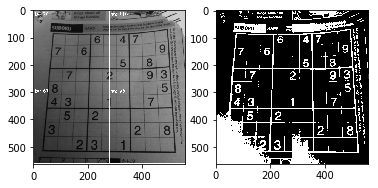

In [3]:
img_gray = cv2.imread('Data_Tutorial5/sudoku.png', 0)

nr_cols = 2
nr_rows = 2
img_height, img_width = img_gray.shape
subimg_width = img_width // nr_cols
subimg_height = img_height // nr_rows
img_thresholded = np.zeros((subimg_height*nr_rows, subimg_width*nr_cols), dtype='uint8')
all_otsu_th = []
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
        # Take the subimage
        y0 = r*subimg_height
        y1 = (r+1)*subimg_height
        x0 = c*subimg_width
        x1 = (c+1)*subimg_width
        subimg = img_gray[y0:y1, x0:x1]
        # Apply Otsu-thresholding to the subimage
        otsu_th,img_otsu = cv2.threshold(subimg,0,256,cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
        all_otsu_th.append(otsu_th)
        # Add the thresholded subimage to the total thresholded image
        img_thresholded[y0:y1, x0:x1] = img_otsu

# Show the results
img_show = img_gray.copy()
i = 0
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
        y0 = r*subimg_height
        y1 = (r+1)*subimg_height
        x0 = c*subimg_width
        x1 = (c+1)*subimg_width
        cv2.rectangle(img_show, (x0,y0), (x1,y1), (255), 2)
        cv2.putText(img_show, "th: %d" % all_otsu_th[i], (x0+5,y0+20), 1, 1, (255), 2)
        i = i+1

plt.subplot(1,2,1)
plt.imshow(img_show, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_thresholded, cmap='gray')
plt.show()

A method that produces even better results in __adaptive thresholding__. In this method, the local average intensity is calculated for every pixel in the image. The intensity of the pixel itself is then compared to this local average. The pixel is classified as foreground if it is higher (or lower) than a certain amount.

The local average at every point can easily be calculated using an averaging filter, with the function `cv2.blur(...)`, as explained in Tutorial 2. Comparing the pixel value and the local average can be done using numpy comparisons `<` or `>`.

__Exercise (adaptive thresholding):__
* Using these tips, implement an adaptive thresholding method that correctly segments the text and the matrix in the image `Data_Tutorial5/sudoku.png`.
* Which neighborhood size and minimal distance from the average works best?
* Try to get this result: 
<img src="Data_Tutorial5/sudoku_mask.png" width="300px">

In [ ]:
img_gray = cv2.imread('Data_Tutorial5/sudoku.png', 0)

# TODO: Add your code here to calculate the local average at all points in the image using cv2.blur
local_average = ...

# TODO: Add your code here to compare the pixels values in img_gray to the local average
mask = ...


# Show results
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.show()